## GNN

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_add_pool
from torch_geometric.data import Data, Batch
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, NormalizeReward, TransformReward
import time
from collections import deque
import random

torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

env = gym.make("LunarLander-v3")
env = RecordEpisodeStatistics(env)
env = TransformReward(env, lambda r: np.clip(r, -10, 10))  
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

Using device: cpu
Action Space: Discrete(4)
Observation Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


In [2]:
num_envs = 1
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128  
gnn_dim = 64      
learning_rate = 3e-4
gamma = 0.99
lamda = 0.95
epsilon = 0.2
value_coef = 0.5
entropy_coef = 0.01  
initial_entropy_coef = 0.1  # Start with higher entropy for exploration
final_entropy_coef = 0.001  # End with lower entropy for exploitation
max_grad_norm = 0.5
num_steps = 256  
num_epochs = 10  
batch_size = 64
num_updates = 2000
test_interval = 10

def lr_lambda(epoch):
    return max(1.0 - epoch / num_updates, 0.1)

def state_to_graph(state):
    # Create more informative node features
    # Node 0: Position (x, y)
    # Node 1: Velocity (x, y)
    # Node 2: Angle and angular velocity
    # Node 3: Leg contact sensors
    # Node 4: Combined state (global features)

    # Normalized features to improve learning
    pos_x_norm = state[0] / 2.0  # Typical range [-1, 1]
    pos_y_norm = (state[1] + 0.5) / 1.5  # Typical range [-0.5, 1]
    vel_x_norm = np.clip(state[2] / 2.0, -1, 1)  # Normalize and clip
    vel_y_norm = np.clip(state[3] / 2.0, -1, 1)  # Normalize and clip
    angle_norm = state[4] / np.pi  # Normalize angle
    ang_vel_norm = np.clip(state[5] / 5.0, -1, 1)  # Normalize and clip

    node_features = torch.tensor([
        [pos_x_norm, pos_y_norm, vel_x_norm * 0.5, vel_y_norm * 0.5, angle_norm * 0.2, 0, state[6], state[7]],  # Position with velocity influence
        [pos_x_norm * 0.5, pos_y_norm * 0.5, vel_x_norm, vel_y_norm, ang_vel_norm * 0.5, 0, 0, 0],  # Velocity with position influence
        [pos_x_norm * 0.2, pos_y_norm * 0.2, 0, 0, angle_norm, ang_vel_norm, 0, 0],  # Angle with position influence
        [0, pos_y_norm * 0.7, 0, vel_y_norm * 0.7, 0, 0, state[6], state[7]],  # Leg contacts with position and velocity influence
        [pos_x_norm, pos_y_norm, vel_x_norm, vel_y_norm, angle_norm, ang_vel_norm, state[6], state[7]]  # Global state node
    ], dtype=torch.float)
    
    # Create edge indices - fully connected graph with directed edges
    edge_index = torch.tensor([
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],  # Source nodes
        [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3]   # Target nodes
    ], dtype=torch.long)
    
    edge_attr = torch.ones(edge_index.shape[1], 1, dtype=torch.float)
    
    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

In [3]:
class ImprovedGNNActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, gnn_dim):
        super(ImprovedGNNActorCritic, self).__init__()
        
        self.conv1 = GCNConv(8, gnn_dim)
        self.gat1 = GATConv(gnn_dim, gnn_dim, heads=2)
        self.conv2 = GCNConv(gnn_dim * 2, gnn_dim)  
        
        self.fc_shared1 = nn.Linear(gnn_dim, hidden_dim)
        self.fc_shared2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.fc_actor = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc_critic = nn.Linear(hidden_dim, hidden_dim // 2)
        
        self.actor = nn.Linear(hidden_dim // 2, action_dim)
        self.critic = nn.Linear(hidden_dim // 2, 1)
        
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.layer_norm_actor = nn.LayerNorm(hidden_dim // 2)
        self.layer_norm_critic = nn.LayerNorm(hidden_dim // 2)
    
    def forward(self, data):
        if isinstance(data, list):
            data = Batch.from_data_list(data)
        
        x, edge_index = data.x, data.edge_index
        
        x1 = F.elu(self.conv1(x, edge_index))
        x2 = self.gat1(x1, edge_index)
        x = F.elu(self.conv2(x2, edge_index))
        
        x_mean = global_mean_pool(x, data.batch)
        x_sum = global_add_pool(x, data.batch)
        x = torch.cat([x_mean, x_sum], dim=1) if data.batch is not None else torch.cat([x.mean(dim=0, keepdim=True), x.sum(dim=0, keepdim=True)], dim=1)
        
        shared_features = F.elu(self.fc_shared1(x_mean))  
        shared_features = self.layer_norm1(shared_features)
        shared_features = F.elu(self.fc_shared2(shared_features))
        shared_features = self.layer_norm2(shared_features)
        
        actor_features = F.elu(self.fc_actor(shared_features))
        actor_features = self.layer_norm_actor(actor_features)
        
        critic_features = F.elu(self.fc_critic(shared_features))
        critic_features = self.layer_norm_critic(critic_features)
        
        action_logits = self.actor(actor_features)
        action_probs = F.softmax(action_logits, dim=1)
        
        # State value
        state_value = self.critic(critic_features)
        
        return action_probs, state_value

model = ImprovedGNNActorCritic(state_dim, action_dim, hidden_dim, gnn_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


In [4]:
def ppo_update(model, optimizer, states, actions, old_log_probs, returns, advantages, update_idx):
    
    states_batch = Batch.from_data_list(states).to(device)
    actions_batch = torch.tensor(actions, dtype=torch.long).to(device)
    old_log_probs_batch = torch.tensor(old_log_probs, dtype=torch.float).to(device)
    returns_batch = torch.tensor(returns, dtype=torch.float).to(device)
    advantages_batch = torch.tensor(advantages, dtype=torch.float).to(device)
    
    advantages_batch = (advantages_batch - advantages_batch.mean()) / (advantages_batch.std() + 1e-8)
    
    progress = min(update_idx / (num_updates * 0.8), 1.0)  # Progress ratio, capped at 1.0
    entropy_coef = initial_entropy_coef * (1 - progress) + final_entropy_coef * progress
    
    policy_losses = []
    value_losses = []
    entropies = []
    kl_divs = []
    early_stop = False
    
    for epoch in range(num_epochs):
        if early_stop:
            break
            
        indices = np.random.permutation(len(states))
        for start_idx in range(0, len(states), batch_size):
            end_idx = min(start_idx + batch_size, len(states))
            batch_indices = indices[start_idx:end_idx]
            
            mb_states_list = [states[i] for i in batch_indices]
            mb_states = Batch.from_data_list(mb_states_list).to(device)
            mb_actions = actions_batch[batch_indices]
            mb_old_log_probs = old_log_probs_batch[batch_indices]
            mb_returns = returns_batch[batch_indices]
            mb_advantages = advantages_batch[batch_indices]
            
            action_probs, state_values = model(mb_states)
            state_values = state_values.squeeze()
            
            dist = torch.distributions.Categorical(action_probs)
            new_log_probs = dist.log_prob(mb_actions)
            entropy = dist.entropy().mean()
            
            # Compute KL divergence for early stopping
            with torch.no_grad():
                old_action_probs, _ = model(mb_states)
                old_dist = torch.distributions.Categorical(old_action_probs)
                kl_div = torch.distributions.kl_divergence(old_dist, dist).mean()
                kl_divs.append(kl_div.item())
                
                # Early stopping based on KL divergence
                if kl_div > 0.015:
                    early_stop = True
                    break
            
            ratio = torch.exp(new_log_probs - mb_old_log_probs)
            
            surr1 = ratio * mb_advantages
            surr2 = torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon) * mb_advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            value_pred_clipped = mb_returns + torch.clamp(
                state_values - mb_returns, -epsilon, epsilon
            )
            value_loss = torch.max(
                F.mse_loss(state_values, mb_returns, reduction='none'),
                F.mse_loss(value_pred_clipped, mb_returns, reduction='none')
            ).mean()
            
            loss = actor_loss + value_coef * value_loss - entropy_coef * entropy
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            
            policy_losses.append(actor_loss.item())
            value_losses.append(value_loss.item())
            entropies.append(entropy.item())
    
    return {
        'policy_loss': np.mean(policy_losses),
        'value_loss': np.mean(value_losses),
        'entropy': np.mean(entropies),
        'kl_div': np.mean(kl_divs),
        'early_stopped': early_stop
    }

def collect_trajectories():
    states = []
    actions = []
    log_probs = []
    rewards = []
    dones = []
    values = []
    
    state, _ = env.reset()
    done = False
    
    for _ in range(num_steps):
        
        state_graph = state_to_graph(state)
        states.append(state_graph)
        
        with torch.no_grad():
            action_probs, value = model([state_graph.to(device)])
            
            exploration_factor = 0.1
            noise = torch.rand_like(action_probs) * exploration_factor
            action_probs = F.softmax(torch.log(action_probs + 1e-8) + noise, dim=1)
            
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
        
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        
        actions.append(action.item())
        log_probs.append(log_prob.item())
        rewards.append(reward)
        dones.append(done)
        values.append(value.item())
        
        state = next_state
        
        if done:
            state, _ = env.reset()
            done = False
    
    returns = []
    advantages = []
    
    with torch.no_grad():
        if not done:
            last_state_graph = state_to_graph(state)
            _, last_value = model([last_state_graph.to(device)])
            last_value = last_value.item()
        else:
            last_value = 0
    
    gae = 0
    running_return = last_value
    
    for t in reversed(range(len(rewards))):
        if t == len(rewards) - 1:
            next_non_terminal = 1.0 - dones[t]
            next_value = last_value
        else:
            next_non_terminal = 1.0 - dones[t]
            next_value = values[t + 1]
        
        delta = rewards[t] + gamma * next_value * next_non_terminal - values[t]
        gae = delta + gamma * lamda * next_non_terminal * gae
        
        running_return = rewards[t] + gamma * next_non_terminal * running_return
        
        returns.insert(0, running_return)
        advantages.insert(0, gae)
    
    return states, actions, log_probs, returns, advantages

def evaluate_policy(model, num_episodes=10):
    eval_env = gym.make("LunarLander-v3", render_mode="rgb_array")
    eval_rewards = []
    success_count = 0
    
    for _ in range(num_episodes):
        state, _ = eval_env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            state_graph = state_to_graph(state)
            with torch.no_grad():
                action_probs, _ = model([state_graph.to(device)])
                action = torch.argmax(action_probs).item()
            
            next_state, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        
        eval_rewards.append(episode_reward)
        if episode_reward > 200:
            success_count += 1
    
    success_rate = success_count / num_episodes
    eval_env.close()
    return np.mean(eval_rewards), success_rate

In [5]:
os.makedirs("models", exist_ok=True)

rewards_history = []
success_rates = []
best_reward = -float('inf')
best_model_path = None
patience = 20
patience_counter = 0

buffer_capacity = 10000
replay_buffer = deque(maxlen=buffer_capacity)

for update in range(1, num_updates + 1):
    start_time = time.time()
    
    states, actions, log_probs, returns, advantages = collect_trajectories()
    
    for i in range(len(states)):
        replay_buffer.append((states[i], actions[i], log_probs[i], returns[i], advantages[i]))
    
    if len(replay_buffer) > batch_size * 10:
        buffer_sample = random.sample(replay_buffer, min(len(replay_buffer) // 2, num_steps))
        buffer_states, buffer_actions, buffer_log_probs, buffer_returns, buffer_advantages = zip(*buffer_sample)
        
        # Mix current experiences with replay buffer
        mixed_states = states[:num_steps//2] + list(buffer_states)[:num_steps//2]
        mixed_actions = actions[:num_steps//2] + list(buffer_actions)[:num_steps//2]
        mixed_log_probs = log_probs[:num_steps//2] + list(buffer_log_probs)[:num_steps//2]
        mixed_returns = returns[:num_steps//2] + list(buffer_returns)[:num_steps//2]
        mixed_advantages = advantages[:num_steps//2] + list(buffer_advantages)[:num_steps//2]
    else:
        mixed_states = states
        mixed_actions = actions
        mixed_log_probs = log_probs
        mixed_returns = returns
        mixed_advantages = advantages
    
    update_info = ppo_update(model, optimizer, mixed_states, mixed_actions, mixed_log_probs, mixed_returns, mixed_advantages, update)
    
    # Update learning rate
    scheduler.step()
    
    # Evaluate
    if update % test_interval == 0:
        mean_reward, success_rate = evaluate_policy(model)
        rewards_history.append(mean_reward)
        success_rates.append(success_rate)
        
        print(f"Update: {update}/{num_updates}, Mean Reward: {mean_reward:.2f}, Success Rate: {success_rate:.2f}, Time: {time.time() - start_time:.2f}s")
        print(f"Policy Loss: {update_info['policy_loss']:.4f}, Value Loss: {update_info['value_loss']:.4f}, Entropy: {update_info['entropy']:.4f}, KL Div: {update_info['kl_div']:.4f}")
        
        if mean_reward > best_reward:
            best_reward = mean_reward
            best_model_path = f"models/gnn_ppo_lunar_lander_best_after.pt"
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
            print(f"New best model saved with reward: {best_reward:.2f}")
        else:
            patience_counter += 1

        if patience_counter >= patience and mean_reward > 200:
            print(f"Early stopping after {patience} evaluations without improvement. Best reward: {best_reward:.2f}")
            break


Update: 10/2000, Mean Reward: -96.03, Success Rate: 0.00, Time: 7.49s
Policy Loss: -0.0221, Value Loss: 3177.6335, Entropy: 1.3618, KL Div: 0.0000
New best model saved with reward: -96.03
Update: 20/2000, Mean Reward: -128.47, Success Rate: 0.00, Time: 8.07s
Policy Loss: 0.0012, Value Loss: 2426.9612, Entropy: 1.3741, KL Div: 0.0000
Update: 30/2000, Mean Reward: -253.98, Success Rate: 0.00, Time: 8.48s
Policy Loss: 0.0017, Value Loss: 2116.7922, Entropy: 1.3513, KL Div: 0.0000
Update: 40/2000, Mean Reward: -251.83, Success Rate: 0.00, Time: 9.52s
Policy Loss: 0.0140, Value Loss: 1140.6481, Entropy: 1.3191, KL Div: 0.0000
Update: 50/2000, Mean Reward: -133.29, Success Rate: 0.00, Time: 13.12s
Policy Loss: -0.0152, Value Loss: 1059.3127, Entropy: 1.3362, KL Div: 0.0000
Update: 60/2000, Mean Reward: -70.52, Success Rate: 0.00, Time: 12.28s
Policy Loss: -0.0151, Value Loss: 435.8296, Entropy: 1.3431, KL Div: 0.0000
New best model saved with reward: -70.52
Update: 70/2000, Mean Reward: -65.

Update: 560/2000, Mean Reward: -305.70, Success Rate: 0.00, Time: 32.83s
Policy Loss: 0.0062, Value Loss: 445.8049, Entropy: 1.2170, KL Div: 0.0000
Update: 570/2000, Mean Reward: -92.39, Success Rate: 0.00, Time: 48.60s
Policy Loss: -0.0044, Value Loss: 255.7293, Entropy: 1.2670, KL Div: 0.0000
Update: 580/2000, Mean Reward: -56.61, Success Rate: 0.00, Time: 42.99s
Policy Loss: 0.0069, Value Loss: 210.2410, Entropy: 1.1521, KL Div: 0.0000
New best model saved with reward: -56.61
Update: 590/2000, Mean Reward: -72.18, Success Rate: 0.00, Time: 45.22s
Policy Loss: -0.0237, Value Loss: 228.0648, Entropy: 1.1727, KL Div: 0.0000
Update: 600/2000, Mean Reward: -62.58, Success Rate: 0.00, Time: 48.71s
Policy Loss: 0.0048, Value Loss: 241.8427, Entropy: 1.1356, KL Div: 0.0000
Update: 610/2000, Mean Reward: -105.55, Success Rate: 0.00, Time: 42.17s
Policy Loss: -0.0027, Value Loss: 225.0465, Entropy: 1.1864, KL Div: 0.0000
Update: 620/2000, Mean Reward: -95.29, Success Rate: 0.00, Time: 39.05s


Update: 1100/2000, Mean Reward: 250.89, Success Rate: 0.90, Time: 11.87s
Policy Loss: 0.0235, Value Loss: 173.0513, Entropy: 1.0639, KL Div: 0.0000
New best model saved with reward: 250.89
Update: 1110/2000, Mean Reward: -5.79, Success Rate: 0.00, Time: 43.20s
Policy Loss: 0.0016, Value Loss: 123.4960, Entropy: 1.0087, KL Div: 0.0000
Update: 1120/2000, Mean Reward: -4.47, Success Rate: 0.00, Time: 47.76s
Policy Loss: 0.0106, Value Loss: 213.1516, Entropy: 1.0391, KL Div: 0.0000
Update: 1130/2000, Mean Reward: 86.82, Success Rate: 0.00, Time: 33.77s
Policy Loss: -0.0012, Value Loss: 146.9537, Entropy: 1.1457, KL Div: 0.0000
Update: 1140/2000, Mean Reward: -296.80, Success Rate: 0.00, Time: 22.62s
Policy Loss: 0.0252, Value Loss: 174.1047, Entropy: 1.0876, KL Div: 0.0000
Update: 1150/2000, Mean Reward: -11.47, Success Rate: 0.00, Time: 42.71s
Policy Loss: -0.0080, Value Loss: 74.1978, Entropy: 1.1662, KL Div: 0.0000
Update: 1160/2000, Mean Reward: -6.08, Success Rate: 0.00, Time: 45.52s


In [8]:
final_model_path = f"models/gnn_ppo_lunar_lander_final.pt"
torch.save(model.state_dict(), final_model_path)

## MLP

In [40]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


environment_name = 'LunarLander-v3'
env = gym.make(environment_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [41]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.actor = nn.Linear(256, action_dim)
        self.critic = nn.Linear(256, 1)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action_probs = F.softmax(self.actor(x), dim=-1)
        state_value = self.critic(x)
        return action_probs, state_value

In [42]:
class PPO:
    def __init__(self, state_dim, action_dim, lr, gamma, K_epochs, eps_clip):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = ActorCritic(state_dim, action_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        rewards = torch.tensor(rewards, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        old_states = torch.stack(memory.states).detach()
        old_actions = torch.stack(memory.actions).detach()
        old_logprobs = torch.stack(memory.logprobs).detach()
        
        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        self.policy_old.load_state_dict(self.policy.state_dict())
    
    def evaluate(self, state, action):
        action_probs, state_value = self.policy(state)
        dist = torch.distributions.Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        return action_logprobs, state_value, dist_entropy
    
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [43]:
def train(env, ppo, memory, max_episodes, max_timesteps, update_timestep):
    episode_rewards = []
    timestep = 0
    
    for episode in range(max_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        for t in range(max_timesteps):
            timestep += 1
            state = torch.FloatTensor(state)
            action_probs, _ = ppo.policy_old(state)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()
            action_logprob = dist.log_prob(action)
            
            next_state, reward, done, truncated, _ = env.step(action.item())
            done = done or truncated 
            
            memory.states.append(state)
            memory.actions.append(action)
            memory.logprobs.append(action_logprob)
            memory.rewards.append(reward)
            memory.is_terminals.append(done)
            
            state = next_state
            episode_reward += reward
            
            if timestep % update_timestep == 0:
                ppo.update(memory)
                memory.clear_memory()
                timestep = 0
            
            if done:
                break
                
        episode_rewards.append(episode_reward)
        if (episode+1) % 10 ==0:
            print(f'Episode: {episode + 1} Reward: {episode_reward}')
            
    return episode_rewards

In [44]:
lr = 3e-4
gamma = 0.99
K_epochs = 4
eps_clip = 0.2
max_episodes = 1400
max_timesteps = 1000
update_timestep = 1000

ppo = PPO(state_dim, action_dim, lr, gamma, K_epochs, eps_clip)
memory = Memory()

episode_rewards = train(env, ppo, memory, max_episodes, max_timesteps, update_timestep)

Episode: 10 Reward: -132.66517870377587
Episode: 20 Reward: -227.21438280953612
Episode: 30 Reward: -272.90979324715204
Episode: 40 Reward: -346.00266147769685
Episode: 50 Reward: -358.7110830469212
Episode: 60 Reward: -363.5721651960075
Episode: 70 Reward: -82.76252255264308
Episode: 80 Reward: -140.55936213519735
Episode: 90 Reward: -65.68914176129964
Episode: 100 Reward: -115.10292504416553
Episode: 110 Reward: -31.918715090393633
Episode: 120 Reward: -176.47728296742196
Episode: 130 Reward: -242.87274321554435
Episode: 140 Reward: -91.8867285594951
Episode: 150 Reward: -93.42927932675357
Episode: 160 Reward: -189.52664330064823
Episode: 170 Reward: -94.68689929027953
Episode: 180 Reward: -124.05829755922403
Episode: 190 Reward: -102.09337091980659
Episode: 200 Reward: -52.274630350636386
Episode: 210 Reward: -93.12795772422827
Episode: 220 Reward: -85.32628556646047
Episode: 230 Reward: -108.17754841866011
Episode: 240 Reward: -89.26574127237397
Episode: 250 Reward: -97.09193534958

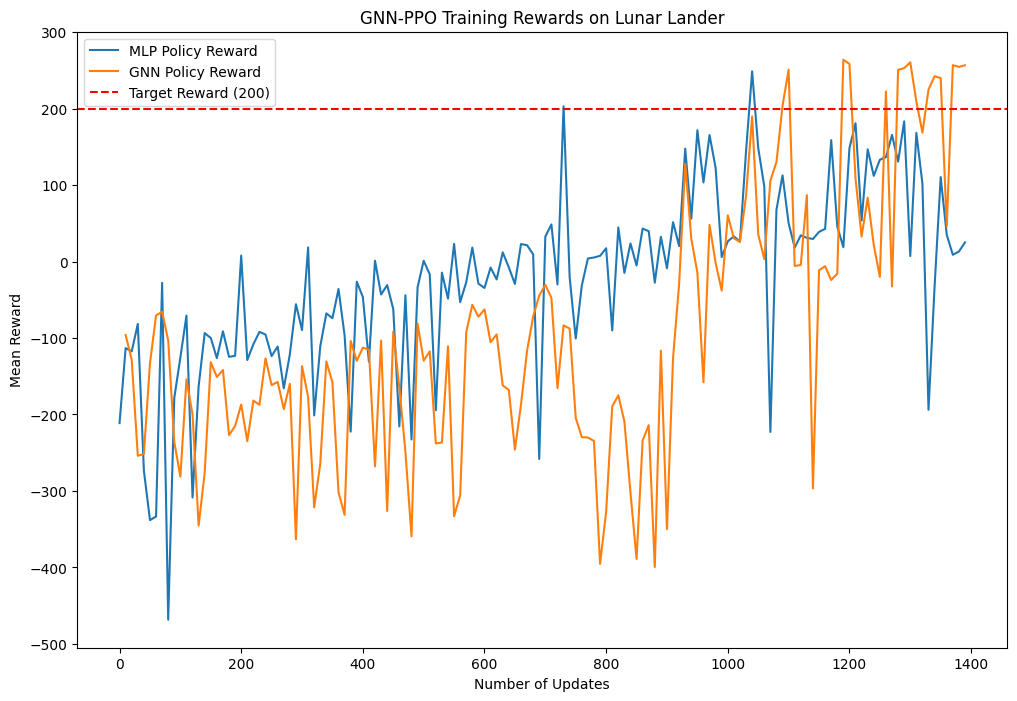

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.plot(range(0, len(episode_rewards), 10), episode_rewards[::10], label="MLP Policy Reward")
plt.plot(range(test_interval, len(rewards_history) * test_interval + 1, test_interval), rewards_history, label="GNN Policy Reward")
plt.axhline(y=200, color='r', linestyle='--', label='Target Reward (200)')

plt.xlabel("Number of Updates")
plt.ylabel("Mean Reward")
plt.title("GNN-PPO Training Rewards on Lunar Lander")
plt.savefig("GNN-VS-MLP Training Rewards.png")
plt.legend()
plt.show()